In [34]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#other libraries
from tqdm import tqdm
import time
import random
import os
import sys
from pathlib import Path
import h5py

#torch specific
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor

#Using newest versions of all libraries

In [35]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *
from imcal import CalorimeterDataset
from imcal import RandomRoll

# Simple CNN cluster image classifier

This notebook provides a framework for classifying cluster images from the ATLAS Open Data dataset [ATLAS simulated samples collection for jet reconstruction training](http://opendata.cern.ch/record/15010).
The dataset contains Monte-Carlo simulated samples corresponding to SM hadronic physics processes. As of now (03.20.2022) only the first part of the dataset is used for this analysis. Using the python script in this project 'cut_njets_root.py', the root file is converted into separate files containing 2D histograms. For each number of Truth Jets a category is created, and all the events associated with that number of Truth Jets is placed in the same file for easy access. Data processing is an essential part of any ML process, and this process of creating images is both naive and not necessarily physically motivated. Future work will focus on creating better images, but for now the simple histograms are used for a 'proof-of-concept' version of the code.

In [36]:
#variables controlled by the user. Change these to fit your specific needs.
VAL_PCT = 0.2 #The percentage of the data to be used as the validation set.
N_EVENTS = 10000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.

#N_LABELS = [0, 1, 2] #A list containing the classes of n number of jets we wish to train for
#LABELS = ["black_holes", "ttbar", "sphalerons"]
#FILENAMES = ["black_holes_9996_events_n.h5", "ttbar_13TeV_pTmin1000_10000_events_n.h5", "sphalerons_10000_events_n.h5"]

LABELS = ["BH_n5_M8", "BH_n2_M12"]
N_LABELS = [0, 1] #integer labels for the model
#FILENAMES = ["BH_n5_M10_10000_events.h5", "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_10000_events.h5"]
FILENAMES = ["BH_n5_M8_10000_events.h5", "BH_n2_M12_10000_events.h5"]
filters = ["saturate"]

CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
DATAPATH = Path("/disk/atlas3/data_MC/2dhistograms/") #The path to the folder containing the histogram files
RES = 100 #resolution

MODEL_NAME = f'convnet' + str(int(time.time())) #A unique name for the model
print(MODEL_NAME)

#Set up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


convnet1667312886
Running on the GPU


In [37]:
def load_hd5_histogram(path:Path, n_events:int):
    with h5py.File(path) as f:
        print (f.keys())
        data = f["images"][0:N_EVENTS]
        #create array
        arr = np.array(data)
        print(f"Loaded data with {len(arr)} entries of shape {np.shape(arr)}")
        print(f"Check max value: {np.max(arr)}")
        #Filters (normalise etc)
        arr = apply_filters(filters, arr, maxvalue=2000)
        return Tensor(arr)

def label_maker(n_classes:int, n_events:int):
    #Creates labels for the classes. The first class gets value [1, 0, .., 0], the next [0, 1, ..., 0] etc
    a = torch.zeros(n_events*n_classes, n_classes, dtype=torch.int)
    for i in range(n_classes):
        for j in range(n_events):
            a[n_events*i + j][i] = 1
    return a

class RandomRoll(torch.nn.Module):
    """
    Applies a random roll to the image along a given axis.
    """
    def __init__(self, roll_axis):
        """
        Args:
            roll_axis (int): Axis to roll along. 0 -> y axis rolling, 1-> x-axis rolling
        """
        super().__init__()
        assert isinstance(roll_axis, int)
        self.roll_axis = roll_axis
        if roll_axis > 2:
            print("You should seriously reconsider this.")

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be rolled.

        Returns:
            PIL Image or Tensor: Randomly rolled image.
        """
        roll_axis = self.roll_axis
        shift = torch.randint(low=0, high=list(img.shape)[roll_axis], size=(1,1)).item()
        img = torch.roll(img, shift, roll_axis)
        return img


def load_datasets(input_files, data_path, n_events, val_pct=0.1):
    #Loads the data files
    val_size = int(n_events*val_pct)
    train_size = int(n_events*(1-val_pct))
    data = [load_hd5_histogram(data_path / file, n_events) for file in input_files]
    #Partitions off training data
    Cal_train = torch.cat([item[0:train_size] for item in data]).float().to(device)
    labels_train = label_maker(len(data), train_size).float().to(device)
    #Testing data
    Cal_test = torch.cat([item[(train_size):(train_size+val_size)] for item in data]).float().to(device)
    labels_test = label_maker(len(data), val_size).float().to(device)
    #Check everything is ok
    print(f"Data has shape {Cal_test[0].shape}. {len(labels_train)} training images and {len(labels_test)} testing images")
    print(f"There are {len(data)} classes.")
    
    transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        RandomRoll(0)
    )

    train_dataset = CalorimeterDataset(Cal_train, labels_train, transform=transforms)
    #train_dataset = CalorimeterDataset(Cal_train, labels_train)
    test_dataset = CalorimeterDataset(Cal_test, labels_test)
    
    return train_dataset, test_dataset

In [38]:
class CircConvNet(nn.Module):
    #This code is heavily inspired by/copied from this tutorial; https://pythonprogramming.net/introduction-deep-learning-neural-network-pytorch/
    def __init__(self, resolution, image_channels, num_classes, stride=1):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=stride, padding_mode="circular", padding=3) # input is 3 channels, 32 output channels, 3x3 kernel / window
        #self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=stride)
        #F.conv2d(F.pad(input, pad=(5,5,5,5), mode='circular'), kernel, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=stride, padding_mode="circular", padding=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=stride)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=stride, padding_mode="circular", padding=3) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=stride, padding_mode="circular", padding=3)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=stride, padding_mode="circular", padding=3)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=stride, padding_mode="circular", padding=3)

        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        x = torch.randn(resolution, resolution, image_channels).view(-1, image_channels, resolution, resolution) #Dummy image used in to_linear func
        print(x.shape)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, num_classes) # 512 in, CLASSES out -> number of classes

    def convs(self, x:Tensor):
        # max pooling over 2x2
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max_pool1(x)
        
        #x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = self.conv3(x)
        x= self.conv4(x)
        x = self.max_pool2(x)
        #x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        
        #x = self.conv5(x)
        #x = self.conv6(x)
        #x = self.max_pool3(x)

        #x = F.max_pool2d(F.relu(self.conv6(x)), (3, 3))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] #calculates the output that needs to be flattened
        return x

    def forward(self, x:Tensor):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

### Load the data

Start by loading the data and then taking a look at it.

In [39]:
#load data
traindata, testdata = load_datasets(FILENAMES, DATAPATH, N_EVENTS, VAL_PCT)

<KeysViewHDF5 ['Events', 'Input', 'Resolution', 'images']>
Loaded data with 10000 entries of shape (10000, 100, 100, 3)
Check max value: 17778.150390625
Applying saturate filter.
<KeysViewHDF5 ['Events', 'Input', 'Resolution', 'images']>
Loaded data with 10000 entries of shape (10000, 100, 100, 3)
Check max value: 20143.6171875
Applying saturate filter.
Data has shape torch.Size([100, 100, 3]). 16000 training images and 4000 testing images
There are 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0, 0, 0, 0], [1, 1, 1, 1]]
[[28, 60, 3, 25], [8066, 8002, 8009, 8032]]
Image shape:  torch.Size([100, 100, 3])


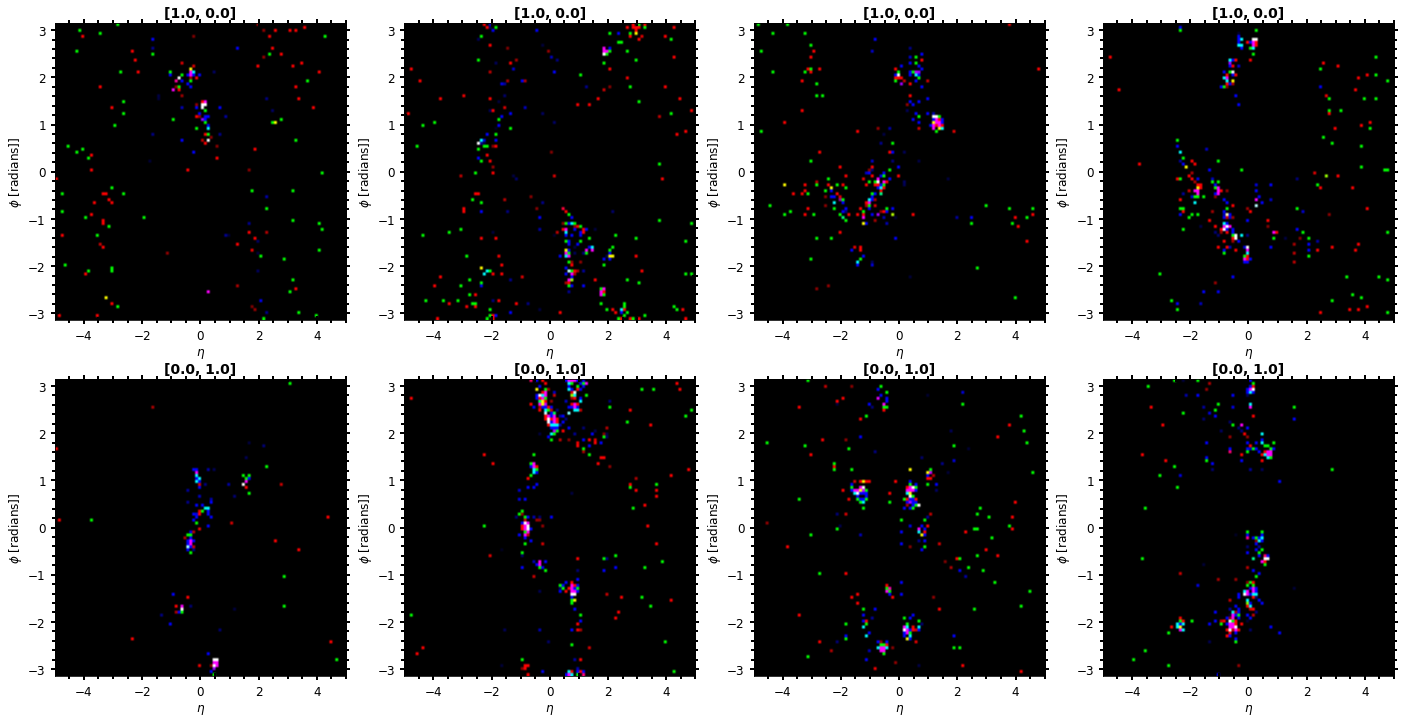

In [40]:
view_data(traindata, 4, CLASSES, N_EVENTS*(1-VAL_PCT))

### Create the NN and start training

We will now create the neural network architecture and the functions for training and testing our network. This is a convoluted neural network CNN. 


In [41]:
#create NN
net = CircConvNet(resolution=RES, image_channels=3, num_classes=CLASSES, stride=3)
net.to(device = device)
#test that nothing major is wrong
testimage, testlabel = traindata.images[0], traindata.img_labels[0]
print(testimage.view(-1, 3, RES, RES).shape)
print(net(testimage.view(-1, 3, RES, RES).to(device)))

torch.Size([1, 3, 100, 100])
torch.Size([1, 3, 100, 100])
tensor([[0.6784, 0.3216]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [46]:
#Set optimizer and learning rate
optimizer = optim.Adam(net.parameters(), lr=0.0005)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#start training
training_results = train(net, traindata, testdata, 2**7, 10, RES, device, optimizer)

100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


### Analyzing our model
Let's take a look at the learning metrics collected in our dataframe. High accuracy on training data and low accuracy on validation implies overtraining. Low accuracy in both categories mean that the network is not learning. Next look at the loss. Loss should go down if the model is learning. If the validation loss starts going up we have overtrained. 

<AxesSubplot:xlabel='Iteration'>

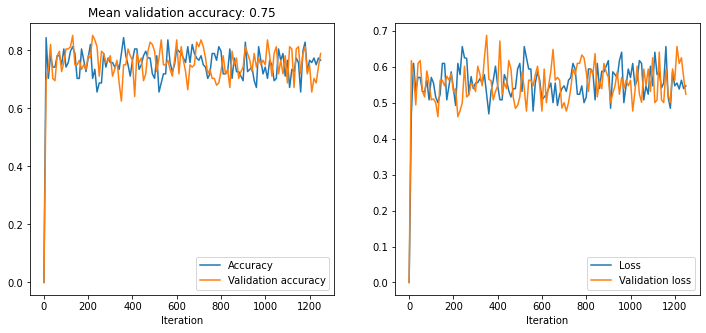

In [47]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])

To further analyse our model we can check how the predictions compare to the true values. This can highlight which classes we are having trouble with.

In [48]:
from sklearn.metrics import accuracy_score
truth, preds = predict(net, testdata, 100, RES, device)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 40/40 [00:00<00:00, 609.58it/s]

4000


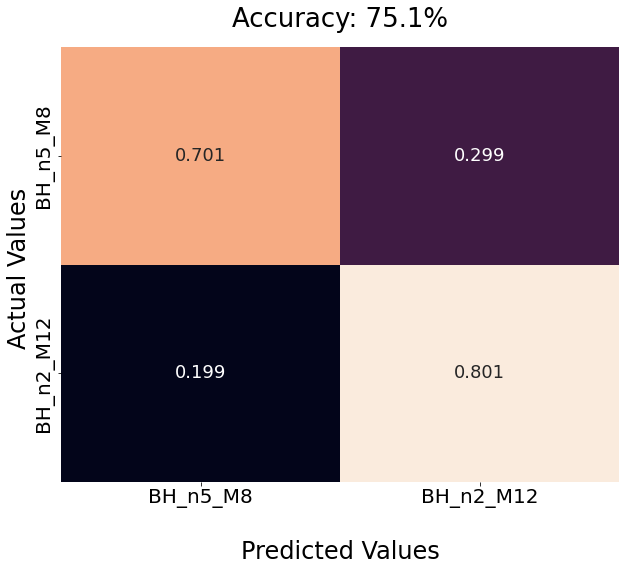

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

fig, ax = plt.subplots(figsize = (10, 8))

#Generate the confusion matrix
cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
cf_matrix = np.round(cf_matrix, 3)
ax = sn.heatmap(cf_matrix, annot=True, cbar=False, cmap='rocket', fmt='g',annot_kws={"size": 18})

#ax.set_title('Confusion matrix\n\n', size=24)
ax.set_xlabel('\nPredicted Values', size=24)
ax.set_ylabel('Actual Values ', size=24)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(LABELS, size=20)
ax.yaxis.set_ticklabels(LABELS, size=20)
ax.set_title(f"Accuracy: {round(accuracy, 4)*100}%", size=26, pad=20)

## Display the visualization of the Confusion Matrix.
plt.show()